In [1]:
import json
import torch
import numpy as np
import random
import os
import pandas as pd
import sys
import random
import math
import argparse
from pathlib import Path
import datetime
import wandb

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import plotly.graph_objects as go

from typing import List, Optional
import fire

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from typing import List

from fairscale.nn.model_parallel.initialize import (
    get_model_parallel_rank,
    initialize_model_parallel,
    model_parallel_is_initialized,
)

In [2]:
# parser = argparse.ArgumentParser(description="Train Encoders and Decoders")

# # Define arguments
# parser.add_argument("--curr_dir",       type=str,  required=False, help="Directory of Program",                                                          default="~/Neurosymbolic-LLM/Programs")
# parser.add_argument("--git_dir",        type=str,  required=False, help="Directory of Main Github",                                                      default="~/Neurosymbolic-LLM")
# parser.add_argument("--chpt_dir",       type=str,  required=False, help="Model Checkpoint Directory",                                                    default="~/.llama/checkpoints/Llama3.1-8B-Instruct")
# parser.add_argument("--tokenizer_path", type=str,  required=False, help="Tokenizer Checkpoint Directory",                                                default="~/.llama/checkpoints/Llama3.1-8B-Instruct/tokenizer.model")
# parser.add_argument("--generate_data",  type=bool, required=False, help="Whether to generate training data for encoder or to train encoder and decoder", default=False)

# args = parser.parse_args()

# curr_dir       = str(Path(args.curr_dir).expanduser())
# git_dir        = str(Path(args.git_dir ).expanduser())
# ckpt_dir       = str(Path(args.chpt_dir).expanduser())
# tokenizer_path = str(Path(args.tokenizer_path).expanduser())
# generate_data  = bool(args.generate_data)

curr_dir       = str(Path("~/Neurosymbolic-LLM/Programs").expanduser())
git_dir        = str(Path("~/Neurosymbolic-LLM").expanduser())
ckpt_dir       = str(Path("~/.llama/checkpoints/Llama3.1-8B-Instruct").expanduser())
tokenizer_path = str(Path("~/.llama/checkpoints/Llama3.1-8B-Instruct/tokenizer.model").expanduser())
generate_data  = bool(False)


In [3]:
sys.path.insert(0, git_dir)

from llama.generation import sample_top_p
from llama.encoder_decoder_networks import Encoder, Decoder, Encoder_Deep, Decoder_Deep
from llama.vsa_engine import *
from llama.utilities import *

from llama import Dialog, Llama



In [4]:
curr_date = datetime.datetime.now().strftime("%Y%m%d")
log_wandb = False

In [5]:
if log_wandb:
    wandb.finish() # If there is an active current run, terminate it
    if generate_data:
        wandb.init(
            project = "Symbolic LLM - Generate Encoder Input Data",
            name    = f"{curr_date}",
        )
    else:
        wandb.init(
            project = "Symbolic LLM - Train Encoders and Decoders",
            name    = f"{curr_date}",
        )


In [6]:
max_seq_len = 10000
max_batch_size = 2
model_parallel_size = 1

top_p = 0.9
temperature = 0
max_gen_len = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))



if generate_data:
    os.environ['RANK'] = "0"
    os.environ['WORLD_SIZE'] = "1"
    os.environ['MASTER_ADDR'] = "127.0.0.2"
    os.environ['MASTER_PORT'] = "29502"
    os.environ['LOCAL_RANK']  = "0"
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    os.environ['TORCH_USE_CUDA_DSA'] = "1"

    generator = Llama.build(
        ckpt_dir=ckpt_dir,
        tokenizer_path=tokenizer_path,
        max_seq_len=max_seq_len,
        max_batch_size=max_batch_size,
    )
else:
    if torch.cuda.is_bf16_supported():
        torch.set_default_dtype(torch.bfloat16)
    else:
        torch.set_default_dtype(torch.float16)

    torch.set_default_device("cuda")


NVIDIA GeForce RTX 4090


'addition-multiplication-division-modulo-gcd-lcm-square_mod-bitwise_and-bitwise_xor-bitwise_or'

In [11]:
max_digits = 5 #15 # maximum representable number is 10**max_digits
VSA_dim = 2048

possible_problems=["addition", "multiplication", "division", "modulo", "gcd", "lcm", "square_mod", "bitwise_and", "bitwise_xor", "bitwise_or"]

SE = SymbolicEngine(VSA_dim=VSA_dim, max_digits=max_digits, possible_problems=possible_problems, 
                    curr_dir=curr_dir)
possible_problems_str = "_".join(possible_problems)
torch.save(SE, f"{curr_dir}/VSA_library/symbolic_engine_VSA_dim_{VSA_dim}_max_digits_{max_digits}_problem_types_{possible_problems_str}.pt")


Using existing VSAs:
 /home/vdhanraj/Neurosymbolic-LLM/Programs/VSA_library/VSA_vector_library_VSAdim_2048_domainSize_14.pt
 /home/vdhanraj/Neurosymbolic-LLM/Programs/VSA_library/VSA_inverse_vector_library_VSAdim_2048_domainSize_14.pt


In [8]:
def print_encoding_accuracy(num1, num2, SE, diff=False, verbose=True):
    final_VSA = SE.generate_VSA(num1, num2)
    decoded_num1, decoded_num2 = SE.decode_VSA(final_VSA, SE.VSA_n1, differentiable=diff).item(), SE.decode_VSA(final_VSA, SE.VSA_n2, differentiable=diff).item()
    #print("Actual vs encoded differences:")
    #print(num1 - decoded_num1, num2 - decoded_num2)
    #print("Digit by digit comparison:")
    #print(str(num1).zfill(SE.max_digits), "\t", str(num2).zfill(SE.max_digits))
    #print(str(int(decoded_num1)).zfill(SE.max_digits), "\t", str(int(decoded_num2)).zfill(SE.max_digits))
    first_num_accuracy  = [1 if str(int(num1)).zfill(SE.max_digits)[i] == str(int(decoded_num1)).zfill(SE.max_digits)[i] else 0 for i in range(SE.max_digits)]
    second_num_accuracy = [1 if str(int(num2)).zfill(SE.max_digits)[i] == str(int(decoded_num2)).zfill(SE.max_digits)[i] else 0 for i in range(SE.max_digits)]
    if verbose:
        print(num1, num2, diff)
        print("Digit accuracy:")
        print(np.mean(first_num_accuracy), np.mean(second_num_accuracy))
    return np.mean(first_num_accuracy), np.mean(second_num_accuracy)

In [9]:
# diff = False
# accuracies = {len(str(num1)) - i: [] for i in range(SE.max_digits)}
# #digits = []
# for run in range(100):
#     num1, num2 = random.randint(1, 10**SE.max_digits), random.randint(1, 10**SE.max_digits)
#     for i in range(len(str(num1))):
#         n1_acc, n2_acc = print_encoding_accuracy(num1 // 10**i, num2 // 10**i, SE, diff, verbose=False)
#         accuracies[len(str(num1)) - i] += [(n1_acc + n2_acc) / 2 * 100]
#         #print()
# plt.plot(accuracies.keys(), [np.mean(i) for i in accuracies.values()])
# plt.xlabel("Number of Digits")
# plt.ylabel("Digit Encoding Accuracy Percentage")
# plt.show()
# # num1, num2 = 10392834, 6817093
# # print_encoding_accuracy(num1, num2, SE, diff)
# # print()
# # num1, num2 = 32123, 21451
# # print_encoding_accuracy(num1, num2, SE, diff)

In [10]:
# Number of times to query the LLM to gather training and testing data
# Final number of samples will be LLM batch size times train/test_data_rounds
train_data_rounds = 10000
test_data_rounds  = 1000

restrict_train_dataset  = train_data_rounds
restrict_test_dataset   = test_data_rounds

# How many rounds to run before saving the hidden state and VSA tensors to disk
save_frequency = 20

layer_numbers = torch.arange(0, 33)  # Which layers should have encoders and decoders trained for them
complexity  = 2 #10 # Complexity of problems to ask, represented by number of digits + 1 (of x and y)
n_samples   = max_batch_size # should be less or equal to  than params.max_batch_size

problem_type = ["multiplication",  "modulo", "gcd", "lcm", "square_mod", "bitwise_and", "bitwise_xor", "bitwise_or"]

if type(problem_type) == type([]):
    problem_str = "_".join(problem_type)
else:
    problem_str = problem_type

tokens_to_keep = 1 #'all' # if set to 'all', then all tokens will be used to calculate the input to the encoder
calculate_end_index = False # if set to true and tokens_to_keep is set to 'all', the input to the encoder will be based on tokens up until the end of user text token (instead of including a few extra tokens telling the LLM it's supposed to provide an output)

# Output directory to write and read saved hidden state and VSA data to
save_dir = f"{curr_dir}/gathered_data_{complexity}_complexity_{tokens_to_keep}_tokens_kept_{calculate_end_index}_calculating_end_index_{train_data_rounds}_train_rounds_{test_data_rounds}_test_rounds_{problem_str}"
os.makedirs(save_dir, exist_ok=True)

if generate_data:
    model_dim = generator.model.model_args.dim
else:
    model_dim = 4096

# Hyperparameters for training the encoder and decoder networks
encoder_decoder_training_batch_size = 512
training_epochs = 10000
learning_rate = 1e-3 # Base learning rate, modified by learning_rate_reduction_factors
#learning_rate_reduction_factors = {25: 0.5, 50:  0.5, 100: 0.1, 250: .4}
learning_rate_reduction_factors = {50: 0.5, 100:  0.5, 250: 0.1, 500: .4}

decoding_training_epochs = 1000
decoding_learning_rate = 1e-3 # Base learning rate, modified by learning_rate_reduction_factors
decoding_learning_rate_reduction_factors = {10: 0.1, 25:  0.5, 100: 0.5, 250: .4}


In [11]:
if generate_data:
    generate_and_save_data(generator=generator, SE=SE, save_dir=save_dir, 
                           rounds=train_data_rounds, train=True,  save_frequency=save_frequency,
                           complexity=complexity, n_samples=n_samples, problem_type=problem_type,
                           tokens_to_keep=tokens_to_keep, calculate_end_index=calculate_end_index, verbose=True)
    print("Training data gathering completed and saved to disk.")

    generate_and_save_data(generator=generator, SE=SE, save_dir=save_dir, 
                           rounds=test_data_rounds,  train=False, save_frequency=save_frequency,
                           complexity=complexity, n_samples=n_samples, problem_type=problem_type,
                           tokens_to_keep=tokens_to_keep, calculate_end_index=calculate_end_index, verbose=True)
    print("Testing data gathering completed and saved to disk.")


On Layer Number: 0
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520


/home/vdhanraj/Neurosymbolic-LLM/llama/utilities.py:620: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  h_stack = torch.load(os.path.join(save_dir, f"{h_path}{r}.pt"))
/home/

On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Round Number: 1020
On Round Number: 1040
On Round Number: 1060
On Round Number: 1080
On Round Number: 1100
On Round Number: 1120
On Round Number: 1140
On Round Number: 1160
On Round Number: 1180
On Round Number: 1200
On Round Number: 1220
On Round Number: 1240
On Round Number: 1260
On Round Number: 1280
On Round Number: 1300
On Round Number: 1320
On Round Number: 1340
On Round Number: 1360
On Round Number: 1380
On Round Number: 1400
On Round Number: 1420
On Round Number: 1440
On Round Nu

On Round Number: 8060
On Round Number: 8080
On Round Number: 8100
On Round Number: 8120
On Round Number: 8140
On Round Number: 8160
On Round Number: 8180
On Round Number: 8200
On Round Number: 8220
On Round Number: 8240
On Round Number: 8260
On Round Number: 8280
On Round Number: 8300
On Round Number: 8320
On Round Number: 8340
On Round Number: 8360
On Round Number: 8380
On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round Number: 8460
On Round Number: 8480
On Round Number: 8500
On Round Number: 8520
On Round Number: 8540
On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round Number: 8780
On Round Number: 8800
On Round Number: 8820
On Round Number: 8840
On Round Number: 8860
On Round Number: 8880
On Round Number: 8900
On Round Number: 8920
On Round Number: 8940
On Round N

On Round Number: 6440
On Round Number: 6460
On Round Number: 6480
On Round Number: 6500
On Round Number: 6520
On Round Number: 6540
On Round Number: 6560
On Round Number: 6580
On Round Number: 6600
On Round Number: 6620
On Round Number: 6640
On Round Number: 6660
On Round Number: 6680
On Round Number: 6700
On Round Number: 6720
On Round Number: 6740
On Round Number: 6760
On Round Number: 6780
On Round Number: 6800
On Round Number: 6820
On Round Number: 6840
On Round Number: 6860
On Round Number: 6880
On Round Number: 6900
On Round Number: 6920
On Round Number: 6940
On Round Number: 6960
On Round Number: 6980
On Round Number: 7000
On Round Number: 7020
On Round Number: 7040
On Round Number: 7060
On Round Number: 7080
On Round Number: 7100
On Round Number: 7120
On Round Number: 7140
On Round Number: 7160
On Round Number: 7180
On Round Number: 7200
On Round Number: 7220
On Round Number: 7240
On Round Number: 7260
On Round Number: 7280
On Round Number: 7300
On Round Number: 7320
On Round N

On Round Number: 3980
On Round Number: 4000
On Round Number: 4020
On Round Number: 4040
On Round Number: 4060
On Round Number: 4080
On Round Number: 4100
On Round Number: 4120
On Round Number: 4140
On Round Number: 4160
On Round Number: 4180
On Round Number: 4200
On Round Number: 4220
On Round Number: 4240
On Round Number: 4260
On Round Number: 4280
On Round Number: 4300
On Round Number: 4320
On Round Number: 4340
On Round Number: 4360
On Round Number: 4380
On Round Number: 4400
On Round Number: 4420
On Round Number: 4440
On Round Number: 4460
On Round Number: 4480
On Round Number: 4500
On Round Number: 4520
On Round Number: 4540
On Round Number: 4560
On Round Number: 4580
On Round Number: 4600
On Round Number: 4620
On Round Number: 4640
On Round Number: 4660
On Round Number: 4680
On Round Number: 4700
On Round Number: 4720
On Round Number: 4740
On Round Number: 4760
On Round Number: 4780
On Round Number: 4800
On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round N

On Round Number: 1920
On Round Number: 1940
On Round Number: 1960
On Round Number: 1980
On Round Number: 2000
On Round Number: 2020
On Round Number: 2040
On Round Number: 2060
On Round Number: 2080
On Round Number: 2100
On Round Number: 2120
On Round Number: 2140
On Round Number: 2160
On Round Number: 2180
On Round Number: 2200
On Round Number: 2220
On Round Number: 2240
On Round Number: 2260
On Round Number: 2280
On Round Number: 2300
On Round Number: 2320
On Round Number: 2340
On Round Number: 2360
On Round Number: 2380
On Round Number: 2400
On Round Number: 2420
On Round Number: 2440
On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round Number: 2800
On Round N

On Layer Number: 4
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 94

On Round Number: 7880
On Round Number: 7900
On Round Number: 7920
On Round Number: 7940
On Round Number: 7960
On Round Number: 7980
On Round Number: 8000
On Round Number: 8020
On Round Number: 8040
On Round Number: 8060
On Round Number: 8080
On Round Number: 8100
On Round Number: 8120
On Round Number: 8140
On Round Number: 8160
On Round Number: 8180
On Round Number: 8200
On Round Number: 8220
On Round Number: 8240
On Round Number: 8260
On Round Number: 8280
On Round Number: 8300
On Round Number: 8320
On Round Number: 8340
On Round Number: 8360
On Round Number: 8380
On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round Number: 8460
On Round Number: 8480
On Round Number: 8500
On Round Number: 8520
On Round Number: 8540
On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round N

On Round Number: 5880
On Round Number: 5900
On Round Number: 5920
On Round Number: 5940
On Round Number: 5960
On Round Number: 5980
On Round Number: 6000
On Round Number: 6020
On Round Number: 6040
On Round Number: 6060
On Round Number: 6080
On Round Number: 6100
On Round Number: 6120
On Round Number: 6140
On Round Number: 6160
On Round Number: 6180
On Round Number: 6200
On Round Number: 6220
On Round Number: 6240
On Round Number: 6260
On Round Number: 6280
On Round Number: 6300
On Round Number: 6320
On Round Number: 6340
On Round Number: 6360
On Round Number: 6380
On Round Number: 6400
On Round Number: 6420
On Round Number: 6440
On Round Number: 6460
On Round Number: 6480
On Round Number: 6500
On Round Number: 6520
On Round Number: 6540
On Round Number: 6560
On Round Number: 6580
On Round Number: 6600
On Round Number: 6620
On Round Number: 6640
On Round Number: 6660
On Round Number: 6680
On Round Number: 6700
On Round Number: 6720
On Round Number: 6740
On Round Number: 6760
On Round N

On Round Number: 4300
On Round Number: 4320
On Round Number: 4340
On Round Number: 4360
On Round Number: 4380
On Round Number: 4400
On Round Number: 4420
On Round Number: 4440
On Round Number: 4460
On Round Number: 4480
On Round Number: 4500
On Round Number: 4520
On Round Number: 4540
On Round Number: 4560
On Round Number: 4580
On Round Number: 4600
On Round Number: 4620
On Round Number: 4640
On Round Number: 4660
On Round Number: 4680
On Round Number: 4700
On Round Number: 4720
On Round Number: 4740
On Round Number: 4760
On Round Number: 4780
On Round Number: 4800
On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round Number: 4880
On Round Number: 4900
On Round Number: 4920
On Round Number: 4940
On Round Number: 4960
On Round Number: 4980
On Round Number: 5000
On Round Number: 5020
On Round Number: 5040
On Round Number: 5060
On Round Number: 5080
On Round Number: 5100
On Round Number: 5120
On Round Number: 5140
On Round Number: 5160
On Round Number: 5180
On Round N

On Round Number: 3020
On Round Number: 3040
On Round Number: 3060
On Round Number: 3080
On Round Number: 3100
On Round Number: 3120
On Round Number: 3140
On Round Number: 3160
On Round Number: 3180
On Round Number: 3200
On Round Number: 3220
On Round Number: 3240
On Round Number: 3260
On Round Number: 3280
On Round Number: 3300
On Round Number: 3320
On Round Number: 3340
On Round Number: 3360
On Round Number: 3380
On Round Number: 3400
On Round Number: 3420
On Round Number: 3440
On Round Number: 3460
On Round Number: 3480
On Round Number: 3500
On Round Number: 3520
On Round Number: 3540
On Round Number: 3560
On Round Number: 3580
On Round Number: 3600
On Round Number: 3620
On Round Number: 3640
On Round Number: 3660
On Round Number: 3680
On Round Number: 3700
On Round Number: 3720
On Round Number: 3740
On Round Number: 3760
On Round Number: 3780
On Round Number: 3800
On Round Number: 3820
On Round Number: 3840
On Round Number: 3860
On Round Number: 3880
On Round Number: 3900
On Round N

On Round Number: 1900
On Round Number: 1920
On Round Number: 1940
On Round Number: 1960
On Round Number: 1980
On Round Number: 2000
On Round Number: 2020
On Round Number: 2040
On Round Number: 2060
On Round Number: 2080
On Round Number: 2100
On Round Number: 2120
On Round Number: 2140
On Round Number: 2160
On Round Number: 2180
On Round Number: 2200
On Round Number: 2220
On Round Number: 2240
On Round Number: 2260
On Round Number: 2280
On Round Number: 2300
On Round Number: 2320
On Round Number: 2340
On Round Number: 2360
On Round Number: 2380
On Round Number: 2400
On Round Number: 2420
On Round Number: 2440
On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round N

On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Round Number: 1020
On Round Number: 1040
On Round Number: 1060
On Round Number: 1080
On Round Number: 1100
On Round Number: 1120
On Round Number: 1140
On Round Number: 1160
On Round Number: 1180
On Round Number: 1200
On Round Number: 1220
On Round Number: 1240
On Round Number: 1260
On Round Number: 1280
On Round Number: 1300
On Round Number: 1320
On Round Number: 1340
On Round Number: 1360
On Round Number: 1380
On Round Number: 1400
On Round Number: 1420
On Round Number: 1440
On Round Number: 1460
On Round Number: 1480
On Round Number: 1500
On Round Number: 1520
On Round Number: 1540
On Round Number: 1560
On Round Number: 1580
On Round Number: 1600
On Round Number: 1620
On

On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round Number: 8780
On Round Number: 8800
On Round Number: 8820
On Round Number: 8840
On Round Number: 8860
On Round Number: 8880
On Round Number: 8900
On Round Number: 8920
On Round Number: 8940
On Round Number: 8960
On Round Number: 8980
On Round Number: 9000
On Round Number: 9020
On Round Number: 9040
On Round Number: 9060
On Round Number: 9080
On Round Number: 9100
On Round Number: 9120
On Round Number: 9140
On Round Number: 9160
On Round Number: 9180
On Round Number: 9200
On Round Number: 9220
On Round Number: 9240
On Round Number: 9260
On Round Number: 9280
On Round Number: 9300
On Round Number: 9320
On Round Number: 9340
On Round Number: 9360
On Round Number: 9380
On Round Number: 9400
On Round Number: 9420
On Round Number: 9440
On Round N

On Round Number: 7560
On Round Number: 7580
On Round Number: 7600
On Round Number: 7620
On Round Number: 7640
On Round Number: 7660
On Round Number: 7680
On Round Number: 7700
On Round Number: 7720
On Round Number: 7740
On Round Number: 7760
On Round Number: 7780
On Round Number: 7800
On Round Number: 7820
On Round Number: 7840
On Round Number: 7860
On Round Number: 7880
On Round Number: 7900
On Round Number: 7920
On Round Number: 7940
On Round Number: 7960
On Round Number: 7980
On Round Number: 8000
On Round Number: 8020
On Round Number: 8040
On Round Number: 8060
On Round Number: 8080
On Round Number: 8100
On Round Number: 8120
On Round Number: 8140
On Round Number: 8160
On Round Number: 8180
On Round Number: 8200
On Round Number: 8220
On Round Number: 8240
On Round Number: 8260
On Round Number: 8280
On Round Number: 8300
On Round Number: 8320
On Round Number: 8340
On Round Number: 8360
On Round Number: 8380
On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round N

On Round Number: 5120
On Round Number: 5140
On Round Number: 5160
On Round Number: 5180
On Round Number: 5200
On Round Number: 5220
On Round Number: 5240
On Round Number: 5260
On Round Number: 5280
On Round Number: 5300
On Round Number: 5320
On Round Number: 5340
On Round Number: 5360
On Round Number: 5380
On Round Number: 5400
On Round Number: 5420
On Round Number: 5440
On Round Number: 5460
On Round Number: 5480
On Round Number: 5500
On Round Number: 5520
On Round Number: 5540
On Round Number: 5560
On Round Number: 5580
On Round Number: 5600
On Round Number: 5620
On Round Number: 5640
On Round Number: 5660
On Round Number: 5680
On Round Number: 5700
On Round Number: 5720
On Round Number: 5740
On Round Number: 5760
On Round Number: 5780
On Round Number: 5800
On Round Number: 5820
On Round Number: 5840
On Round Number: 5860
On Round Number: 5880
On Round Number: 5900
On Round Number: 5920
On Round Number: 5940
On Round Number: 5960
On Round Number: 5980
On Round Number: 6000
On Round N

On Round Number: 4160
On Round Number: 4180
On Round Number: 4200
On Round Number: 4220
On Round Number: 4240
On Round Number: 4260
On Round Number: 4280
On Round Number: 4300
On Round Number: 4320
On Round Number: 4340
On Round Number: 4360
On Round Number: 4380
On Round Number: 4400
On Round Number: 4420
On Round Number: 4440
On Round Number: 4460
On Round Number: 4480
On Round Number: 4500
On Round Number: 4520
On Round Number: 4540
On Round Number: 4560
On Round Number: 4580
On Round Number: 4600
On Round Number: 4620
On Round Number: 4640
On Round Number: 4660
On Round Number: 4680
On Round Number: 4700
On Round Number: 4720
On Round Number: 4740
On Round Number: 4760
On Round Number: 4780
On Round Number: 4800
On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round Number: 4880
On Round Number: 4900
On Round Number: 4920
On Round Number: 4940
On Round Number: 4960
On Round Number: 4980
On Round Number: 5000
On Round Number: 5020
On Round Number: 5040
On Round N

On Round Number: 1800
On Round Number: 1820
On Round Number: 1840
On Round Number: 1860
On Round Number: 1880
On Round Number: 1900
On Round Number: 1920
On Round Number: 1940
On Round Number: 1960
On Round Number: 1980
On Round Number: 2000
On Round Number: 2020
On Round Number: 2040
On Round Number: 2060
On Round Number: 2080
On Round Number: 2100
On Round Number: 2120
On Round Number: 2140
On Round Number: 2160
On Round Number: 2180
On Round Number: 2200
On Round Number: 2220
On Round Number: 2240
On Round Number: 2260
On Round Number: 2280
On Round Number: 2300
On Round Number: 2320
On Round Number: 2340
On Round Number: 2360
On Round Number: 2380
On Round Number: 2400
On Round Number: 2420
On Round Number: 2440
On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round N

On Round Number: 9960
On Round Number: 9980
On Round Number: 10000
On Layer Number: 14
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Numbe

On Round Number: 9080
On Round Number: 9100
On Round Number: 9120
On Round Number: 9140
On Round Number: 9160
On Round Number: 9180
On Round Number: 9200
On Round Number: 9220
On Round Number: 9240
On Round Number: 9260
On Round Number: 9280
On Round Number: 9300
On Round Number: 9320
On Round Number: 9340
On Round Number: 9360
On Round Number: 9380
On Round Number: 9400
On Round Number: 9420
On Round Number: 9440
On Round Number: 9460
On Round Number: 9480
On Round Number: 9500
On Round Number: 9520
On Round Number: 9540
On Round Number: 9560
On Round Number: 9580
On Round Number: 9600
On Round Number: 9620
On Round Number: 9640
On Round Number: 9660
On Round Number: 9680
On Round Number: 9700
On Round Number: 9720
On Round Number: 9740
On Round Number: 9760
On Round Number: 9780
On Round Number: 9800
On Round Number: 9820
On Round Number: 9840
On Round Number: 9860
On Round Number: 9880
On Round Number: 9900
On Round Number: 9920
On Round Number: 9940
On Round Number: 9960
On Round N

On Round Number: 6880
On Round Number: 6900
On Round Number: 6920
On Round Number: 6940
On Round Number: 6960
On Round Number: 6980
On Round Number: 7000
On Round Number: 7020
On Round Number: 7040
On Round Number: 7060
On Round Number: 7080
On Round Number: 7100
On Round Number: 7120
On Round Number: 7140
On Round Number: 7160
On Round Number: 7180
On Round Number: 7200
On Round Number: 7220
On Round Number: 7240
On Round Number: 7260
On Round Number: 7280
On Round Number: 7300
On Round Number: 7320
On Round Number: 7340
On Round Number: 7360
On Round Number: 7380
On Round Number: 7400
On Round Number: 7420
On Round Number: 7440
On Round Number: 7460
On Round Number: 7480
On Round Number: 7500
On Round Number: 7520
On Round Number: 7540
On Round Number: 7560
On Round Number: 7580
On Round Number: 7600
On Round Number: 7620
On Round Number: 7640
On Round Number: 7660
On Round Number: 7680
On Round Number: 7700
On Round Number: 7720
On Round Number: 7740
On Round Number: 7760
On Round N

On Round Number: 4380
On Round Number: 4400
On Round Number: 4420
On Round Number: 4440
On Round Number: 4460
On Round Number: 4480
On Round Number: 4500
On Round Number: 4520
On Round Number: 4540
On Round Number: 4560
On Round Number: 4580
On Round Number: 4600
On Round Number: 4620
On Round Number: 4640
On Round Number: 4660
On Round Number: 4680
On Round Number: 4700
On Round Number: 4720
On Round Number: 4740
On Round Number: 4760
On Round Number: 4780
On Round Number: 4800
On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round Number: 4880
On Round Number: 4900
On Round Number: 4920
On Round Number: 4940
On Round Number: 4960
On Round Number: 4980
On Round Number: 5000
On Round Number: 5020
On Round Number: 5040
On Round Number: 5060
On Round Number: 5080
On Round Number: 5100
On Round Number: 5120
On Round Number: 5140
On Round Number: 5160
On Round Number: 5180
On Round Number: 5200
On Round Number: 5220
On Round Number: 5240
On Round Number: 5260
On Round N

On Round Number: 2220
On Round Number: 2240
On Round Number: 2260
On Round Number: 2280
On Round Number: 2300
On Round Number: 2320
On Round Number: 2340
On Round Number: 2360
On Round Number: 2380
On Round Number: 2400
On Round Number: 2420
On Round Number: 2440
On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round Number: 2800
On Round Number: 2820
On Round Number: 2840
On Round Number: 2860
On Round Number: 2880
On Round Number: 2900
On Round Number: 2920
On Round Number: 2940
On Round Number: 2960
On Round Number: 2980
On Round Number: 3000
On Round Number: 3020
On Round Number: 3040
On Round Number: 3060
On Round Number: 3080
On Round Number: 3100
On Round N

On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number

On Round Number: 8160
On Round Number: 8180
On Round Number: 8200
On Round Number: 8220
On Round Number: 8240
On Round Number: 8260
On Round Number: 8280
On Round Number: 8300
On Round Number: 8320
On Round Number: 8340
On Round Number: 8360
On Round Number: 8380
On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round Number: 8460
On Round Number: 8480
On Round Number: 8500
On Round Number: 8520
On Round Number: 8540
On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round Number: 8780
On Round Number: 8800
On Round Number: 8820
On Round Number: 8840
On Round Number: 8860
On Round Number: 8880
On Round Number: 8900
On Round Number: 8920
On Round Number: 8940
On Round Number: 8960
On Round Number: 8980
On Round Number: 9000
On Round Number: 9020
On Round Number: 9040
On Round N

On Round Number: 5940
On Round Number: 5960
On Round Number: 5980
On Round Number: 6000
On Round Number: 6020
On Round Number: 6040
On Round Number: 6060
On Round Number: 6080
On Round Number: 6100
On Round Number: 6120
On Round Number: 6140
On Round Number: 6160
On Round Number: 6180
On Round Number: 6200
On Round Number: 6220
On Round Number: 6240
On Round Number: 6260
On Round Number: 6280
On Round Number: 6300
On Round Number: 6320
On Round Number: 6340
On Round Number: 6360
On Round Number: 6380
On Round Number: 6400
On Round Number: 6420
On Round Number: 6440
On Round Number: 6460
On Round Number: 6480
On Round Number: 6500
On Round Number: 6520
On Round Number: 6540
On Round Number: 6560
On Round Number: 6580
On Round Number: 6600
On Round Number: 6620
On Round Number: 6640
On Round Number: 6660
On Round Number: 6680
On Round Number: 6700
On Round Number: 6720
On Round Number: 6740
On Round Number: 6760
On Round Number: 6780
On Round Number: 6800
On Round Number: 6820
On Round N

On Round Number: 4660
On Round Number: 4680
On Round Number: 4700
On Round Number: 4720
On Round Number: 4740
On Round Number: 4760
On Round Number: 4780
On Round Number: 4800
On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round Number: 4880
On Round Number: 4900
On Round Number: 4920
On Round Number: 4940
On Round Number: 4960
On Round Number: 4980
On Round Number: 5000
On Round Number: 5020
On Round Number: 5040
On Round Number: 5060
On Round Number: 5080
On Round Number: 5100
On Round Number: 5120
On Round Number: 5140
On Round Number: 5160
On Round Number: 5180
On Round Number: 5200
On Round Number: 5220
On Round Number: 5240
On Round Number: 5260
On Round Number: 5280
On Round Number: 5300
On Round Number: 5320
On Round Number: 5340
On Round Number: 5360
On Round Number: 5380
On Round Number: 5400
On Round Number: 5420
On Round Number: 5440
On Round Number: 5460
On Round Number: 5480
On Round Number: 5500
On Round Number: 5520
On Round Number: 5540
On Round N

On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round Number: 2800
On Round Number: 2820
On Round Number: 2840
On Round Number: 2860
On Round Number: 2880
On Round Number: 2900
On Round Number: 2920
On Round Number: 2940
On Round Number: 2960
On Round Number: 2980
On Round Number: 3000
On Round Number: 3020
On Round Number: 3040
On Round Number: 3060
On Round Number: 3080
On Round Number: 3100
On Round Number: 3120
On Round Number: 3140
On Round Number: 3160
On Round Number: 3180
On Round Number: 3200
On Round Number: 3220
On Round Number: 3240
On Round Number: 3260
On Round Number: 3280
On Round Number: 3300
On Round Number: 3320
On Round Number: 3340
On Round Number: 3360
On Round Number: 3380
On Round Number: 3400
On Round Number: 3420
On Round N

On Layer Number: 22
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 9

On Round Number: 9100
On Round Number: 9120
On Round Number: 9140
On Round Number: 9160
On Round Number: 9180
On Round Number: 9200
On Round Number: 9220
On Round Number: 9240
On Round Number: 9260
On Round Number: 9280
On Round Number: 9300
On Round Number: 9320
On Round Number: 9340
On Round Number: 9360
On Round Number: 9380
On Round Number: 9400
On Round Number: 9420
On Round Number: 9440
On Round Number: 9460
On Round Number: 9480
On Round Number: 9500
On Round Number: 9520
On Round Number: 9540
On Round Number: 9560
On Round Number: 9580
On Round Number: 9600
On Round Number: 9620
On Round Number: 9640
On Round Number: 9660
On Round Number: 9680
On Round Number: 9700
On Round Number: 9720
On Round Number: 9740
On Round Number: 9760
On Round Number: 9780
On Round Number: 9800
On Round Number: 9820
On Round Number: 9840
On Round Number: 9860
On Round Number: 9880
On Round Number: 9900
On Round Number: 9920
On Round Number: 9940
On Round Number: 9960
On Round Number: 9980
On Round N

On Round Number: 6980
On Round Number: 7000
On Round Number: 7020
On Round Number: 7040
On Round Number: 7060
On Round Number: 7080
On Round Number: 7100
On Round Number: 7120
On Round Number: 7140
On Round Number: 7160
On Round Number: 7180
On Round Number: 7200
On Round Number: 7220
On Round Number: 7240
On Round Number: 7260
On Round Number: 7280
On Round Number: 7300
On Round Number: 7320
On Round Number: 7340
On Round Number: 7360
On Round Number: 7380
On Round Number: 7400
On Round Number: 7420
On Round Number: 7440
On Round Number: 7460
On Round Number: 7480
On Round Number: 7500
On Round Number: 7520
On Round Number: 7540
On Round Number: 7560
On Round Number: 7580
On Round Number: 7600
On Round Number: 7620
On Round Number: 7640
On Round Number: 7660
On Round Number: 7680
On Round Number: 7700
On Round Number: 7720
On Round Number: 7740
On Round Number: 7760
On Round Number: 7780
On Round Number: 7800
On Round Number: 7820
On Round Number: 7840
On Round Number: 7860
On Round N

On Round Number: 4820
On Round Number: 4840
On Round Number: 4860
On Round Number: 4880
On Round Number: 4900
On Round Number: 4920
On Round Number: 4940
On Round Number: 4960
On Round Number: 4980
On Round Number: 5000
On Round Number: 5020
On Round Number: 5040
On Round Number: 5060
On Round Number: 5080
On Round Number: 5100
On Round Number: 5120
On Round Number: 5140
On Round Number: 5160
On Round Number: 5180
On Round Number: 5200
On Round Number: 5220
On Round Number: 5240
On Round Number: 5260
On Round Number: 5280
On Round Number: 5300
On Round Number: 5320
On Round Number: 5340
On Round Number: 5360
On Round Number: 5380
On Round Number: 5400
On Round Number: 5420
On Round Number: 5440
On Round Number: 5460
On Round Number: 5480
On Round Number: 5500
On Round Number: 5520
On Round Number: 5540
On Round Number: 5560
On Round Number: 5580
On Round Number: 5600
On Round Number: 5620
On Round Number: 5640
On Round Number: 5660
On Round Number: 5680
On Round Number: 5700
On Round N

On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round Number: 2800
On Round Number: 2820
On Round Number: 2840
On Round Number: 2860
On Round Number: 2880
On Round Number: 2900
On Round Number: 2920
On Round Number: 2940
On Round Number: 2960
On Round Number: 2980
On Round Number: 3000
On Round Number: 3020
On Round Number: 3040
On Round Number: 3060
On Round Number: 3080
On Round Number: 3100
On Round Number: 3120
On Round Number: 3140
On Round Number: 3160
On Round Number: 3180
On Round Number: 3200
On Round Number: 3220
On Round Number: 3240
On Round Number: 3260
On Round Number: 3280
On Round Number: 3300
On Round Number: 3320
On Round Number: 3340
On Round N

On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Round Number: 1020
On Round Number: 1040
On Round Number: 1060
On Round Number: 1080
On Round Number: 1100
On Round Number: 1120
On Round Number: 1140
On Round Number: 1160
On Round Number: 1180
On Round Number: 1200
On Round Number: 1220
On Round Number: 1240
On Round Number: 1260
On Round Number: 1280
On Round Number: 1300
On Round Number: 1320
On Round Number: 1340
On Round Number: 1360
On Round Number: 1380
On Round Number: 1400
On Round Number: 1420
On Round Number: 1440
On Round Number: 1460
On Round Number: 1480
On Round Number: 1500
On Round Number: 1520
On Round Number: 1540
On Round Number: 1560
On Round Number: 1580
On Round Number: 1600
On Round Number: 1620
On Round Number: 1640
O

On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round Number: 8460
On Round Number: 8480
On Round Number: 8500
On Round Number: 8520
On Round Number: 8540
On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round Number: 8780
On Round Number: 8800
On Round Number: 8820
On Round Number: 8840
On Round Number: 8860
On Round Number: 8880
On Round Number: 8900
On Round Number: 8920
On Round Number: 8940
On Round Number: 8960
On Round Number: 8980
On Round Number: 9000
On Round Number: 9020
On Round Number: 9040
On Round Number: 9060
On Round Number: 9080
On Round Number: 9100
On Round Number: 9120
On Round Number: 9140
On Round Number: 9160
On Round Number: 9180
On Round Number: 9200
On Round Number: 9220
On Round Number: 9240
On Round Number: 9260
On Round Number: 9280
On Round N

On Round Number: 5920
On Round Number: 5940
On Round Number: 5960
On Round Number: 5980
On Round Number: 6000
On Round Number: 6020
On Round Number: 6040
On Round Number: 6060
On Round Number: 6080
On Round Number: 6100
On Round Number: 6120
On Round Number: 6140
On Round Number: 6160
On Round Number: 6180
On Round Number: 6200
On Round Number: 6220
On Round Number: 6240
On Round Number: 6260
On Round Number: 6280
On Round Number: 6300
On Round Number: 6320
On Round Number: 6340
On Round Number: 6360
On Round Number: 6380
On Round Number: 6400
On Round Number: 6420
On Round Number: 6440
On Round Number: 6460
On Round Number: 6480
On Round Number: 6500
On Round Number: 6520
On Round Number: 6540
On Round Number: 6560
On Round Number: 6580
On Round Number: 6600
On Round Number: 6620
On Round Number: 6640
On Round Number: 6660
On Round Number: 6680
On Round Number: 6700
On Round Number: 6720
On Round Number: 6740
On Round Number: 6760
On Round Number: 6780
On Round Number: 6800
On Round N

On Round Number: 3580
On Round Number: 3600
On Round Number: 3620
On Round Number: 3640
On Round Number: 3660
On Round Number: 3680
On Round Number: 3700
On Round Number: 3720
On Round Number: 3740
On Round Number: 3760
On Round Number: 3780
On Round Number: 3800
On Round Number: 3820
On Round Number: 3840
On Round Number: 3860
On Round Number: 3880
On Round Number: 3900
On Round Number: 3920
On Round Number: 3940
On Round Number: 3960
On Round Number: 3980
On Round Number: 4000
On Round Number: 4020
On Round Number: 4040
On Round Number: 4060
On Round Number: 4080
On Round Number: 4100
On Round Number: 4120
On Round Number: 4140
On Round Number: 4160
On Round Number: 4180
On Round Number: 4200
On Round Number: 4220
On Round Number: 4240
On Round Number: 4260
On Round Number: 4280
On Round Number: 4300
On Round Number: 4320
On Round Number: 4340
On Round Number: 4360
On Round Number: 4380
On Round Number: 4400
On Round Number: 4420
On Round Number: 4440
On Round Number: 4460
On Round N

On Round Number: 1980
On Round Number: 2000
On Round Number: 2020
On Round Number: 2040
On Round Number: 2060
On Round Number: 2080
On Round Number: 2100
On Round Number: 2120
On Round Number: 2140
On Round Number: 2160
On Round Number: 2180
On Round Number: 2200
On Round Number: 2220
On Round Number: 2240
On Round Number: 2260
On Round Number: 2280
On Round Number: 2300
On Round Number: 2320
On Round Number: 2340
On Round Number: 2360
On Round Number: 2380
On Round Number: 2400
On Round Number: 2420
On Round Number: 2440
On Round Number: 2460
On Round Number: 2480
On Round Number: 2500
On Round Number: 2520
On Round Number: 2540
On Round Number: 2560
On Round Number: 2580
On Round Number: 2600
On Round Number: 2620
On Round Number: 2640
On Round Number: 2660
On Round Number: 2680
On Round Number: 2700
On Round Number: 2720
On Round Number: 2740
On Round Number: 2760
On Round Number: 2780
On Round Number: 2800
On Round Number: 2820
On Round Number: 2840
On Round Number: 2860
On Round N

On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Round Number: 1020
On Round Number: 1040
On Round N

On Round Number: 7940
On Round Number: 7960
On Round Number: 7980
On Round Number: 8000
On Round Number: 8020
On Round Number: 8040
On Round Number: 8060
On Round Number: 8080
On Round Number: 8100
On Round Number: 8120
On Round Number: 8140
On Round Number: 8160
On Round Number: 8180
On Round Number: 8200
On Round Number: 8220
On Round Number: 8240
On Round Number: 8260
On Round Number: 8280
On Round Number: 8300
On Round Number: 8320
On Round Number: 8340
On Round Number: 8360
On Round Number: 8380
On Round Number: 8400
On Round Number: 8420
On Round Number: 8440
On Round Number: 8460
On Round Number: 8480
On Round Number: 8500
On Round Number: 8520
On Round Number: 8540
On Round Number: 8560
On Round Number: 8580
On Round Number: 8600
On Round Number: 8620
On Round Number: 8640
On Round Number: 8660
On Round Number: 8680
On Round Number: 8700
On Round Number: 8720
On Round Number: 8740
On Round Number: 8760
On Round Number: 8780
On Round Number: 8800
On Round Number: 8820
On Round N

On Round Number: 7060
On Round Number: 7080
On Round Number: 7100
On Round Number: 7120
On Round Number: 7140
On Round Number: 7160
On Round Number: 7180
On Round Number: 7200
On Round Number: 7220
On Round Number: 7240
On Round Number: 7260
On Round Number: 7280
On Round Number: 7300
On Round Number: 7320
On Round Number: 7340
On Round Number: 7360
On Round Number: 7380
On Round Number: 7400
On Round Number: 7420
On Round Number: 7440
On Round Number: 7460
On Round Number: 7480
On Round Number: 7500
On Round Number: 7520
On Round Number: 7540
On Round Number: 7560
On Round Number: 7580
On Round Number: 7600
On Round Number: 7620
On Round Number: 7640
On Round Number: 7660
On Round Number: 7680
On Round Number: 7700
On Round Number: 7720
On Round Number: 7740
On Round Number: 7760
On Round Number: 7780
On Round Number: 7800
On Round Number: 7820
On Round Number: 7840
On Round Number: 7860
On Round Number: 7880
On Round Number: 7900
On Round Number: 7920
On Round Number: 7940
On Round N

On Round Number: 5300
On Round Number: 5320
On Round Number: 5340
On Round Number: 5360
On Round Number: 5380
On Round Number: 5400
On Round Number: 5420
On Round Number: 5440
On Round Number: 5460
On Round Number: 5480
On Round Number: 5500
On Round Number: 5520
On Round Number: 5540
On Round Number: 5560
On Round Number: 5580
On Round Number: 5600
On Round Number: 5620
On Round Number: 5640
On Round Number: 5660
On Round Number: 5680
On Round Number: 5700
On Round Number: 5720
On Round Number: 5740
On Round Number: 5760
On Round Number: 5780
On Round Number: 5800
On Round Number: 5820
On Round Number: 5840
On Round Number: 5860
On Round Number: 5880
On Round Number: 5900
On Round Number: 5920
On Round Number: 5940
On Round Number: 5960
On Round Number: 5980
On Round Number: 6000
On Round Number: 6020
On Round Number: 6040
On Round Number: 6060
On Round Number: 6080
On Round Number: 6100
On Round Number: 6120
On Round Number: 6140
On Round Number: 6160
On Round Number: 6180
On Round N

On Layer Number: 4
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 94

On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Layer Number: 12
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 

On Round Number: 340
On Round Number: 360
On Round Number: 380
On Round Number: 400
On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Layer Number: 22
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 

On Round Number: 420
On Round Number: 440
On Round Number: 460
On Round Number: 480
On Round Number: 500
On Round Number: 520
On Round Number: 540
On Round Number: 560
On Round Number: 580
On Round Number: 600
On Round Number: 620
On Round Number: 640
On Round Number: 660
On Round Number: 680
On Round Number: 700
On Round Number: 720
On Round Number: 740
On Round Number: 760
On Round Number: 780
On Round Number: 800
On Round Number: 820
On Round Number: 840
On Round Number: 860
On Round Number: 880
On Round Number: 900
On Round Number: 920
On Round Number: 940
On Round Number: 960
On Round Number: 980
On Round Number: 1000
On Layer Number: 31
On Round Number: 20
On Round Number: 40
On Round Number: 60
On Round Number: 80
On Round Number: 100
On Round Number: 120
On Round Number: 140
On Round Number: 160
On Round Number: 180
On Round Number: 200
On Round Number: 220
On Round Number: 240
On Round Number: 260
On Round Number: 280
On Round Number: 300
On Round Number: 320
On Round Number: 

Epoch: 6200 Running Loss: 0.030287540320194126 	Total gradient norm: 0.12977294921875
Epoch: 6300 Running Loss: 0.0302755644827178 	Total gradient norm: 0.13236083984375
Epoch: 6400 Running Loss: 0.030284904711174242 	Total gradient norm: 0.13226318359375
Epoch: 6500 Running Loss: 0.030253323641690342 	Total gradient norm: 0.13165283203125
Epoch: 6600 Running Loss: 0.030196912360913826 	Total gradient norm: 0.13302001953125
Epoch: 6700 Running Loss: 0.030313850171638256 	Total gradient norm: 0.1311767578125
Epoch: 6800 Running Loss: 0.03033696954900568 	Total gradient norm: 0.13284912109375
Epoch: 6900 Running Loss: 0.03022937196673769 	Total gradient norm: 0.130078125
Epoch: 7000 Running Loss: 0.03029077703302557 	Total gradient norm: 0.1307861328125
Epoch: 7100 Running Loss: 0.03021087646484375 	Total gradient norm: 0.1328125
Epoch: 7200 Running Loss: 0.03027047821969697 	Total gradient norm: 0.13118896484375
Epoch: 7300 Running Loss: 0.030206992409446024 	Total gradient norm: 0.1299

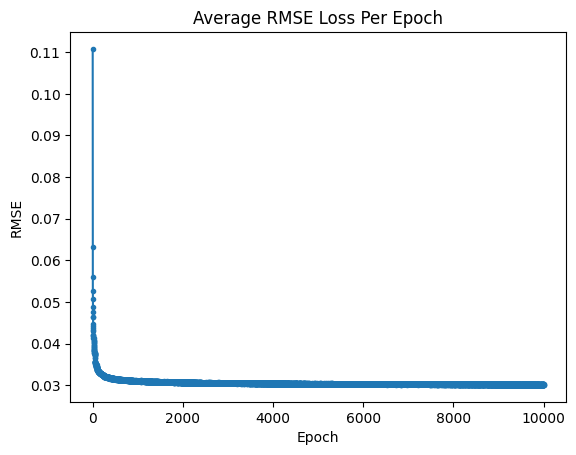

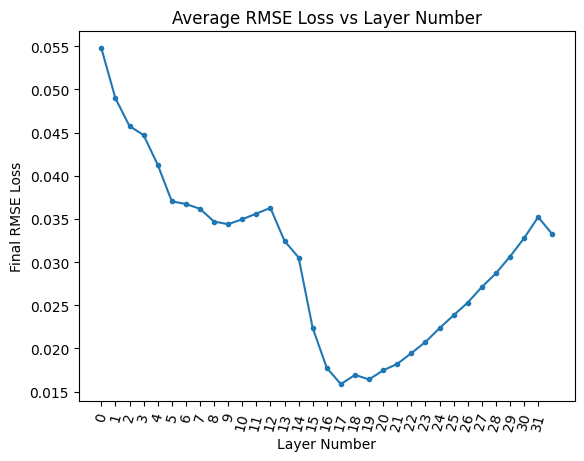

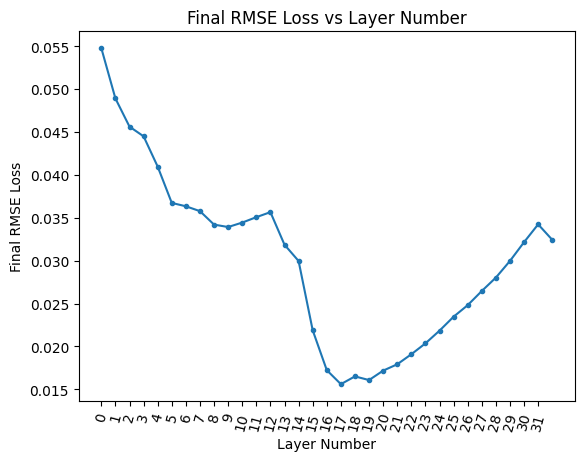

Epoch: 5 Running Loss: 0.13495178800640684 	Total gradient norm: 0.005289459228515625
Learning Rate changed to: 0.0001
Epoch: 10 Running Loss: 0.13253581018158883 	Total gradient norm: 0.004862213134765625
Epoch: 15 Running Loss: 0.13134369705662582 	Total gradient norm: 0.004869842529296875
Epoch: 20 Running Loss: 0.1305711197130608 	Total gradient norm: 0.004862213134765625
Learning Rate changed to: 5e-05
Epoch: 25 Running Loss: 0.12993438894098455 	Total gradient norm: 0.00487060546875
Epoch: 30 Running Loss: 0.12944573200110235 	Total gradient norm: 0.004857635498046875
Epoch: 35 Running Loss: 0.12894400683316318 	Total gradient norm: 0.004872894287109375
Epoch: 40 Running Loss: 0.12852754592895507 	Total gradient norm: 0.004863739013671875
Epoch: 45 Running Loss: 0.12816795724810975 	Total gradient norm: 0.00487518310546875
Epoch: 50 Running Loss: 0.1279448494766698 	Total gradient norm: 0.00485992431640625
Epoch: 55 Running Loss: 0.12742027658404725 	Total gradient norm: 0.004860

Epoch: 475 Running Loss: 0.12435169725707085 	Total gradient norm: 0.00487060546875
Epoch: 480 Running Loss: 0.12420708085551406 	Total gradient norm: 0.0048614501953125
Epoch: 485 Running Loss: 0.12429103490078088 	Total gradient norm: 0.0048583984375
Epoch: 490 Running Loss: 0.12407386339072025 	Total gradient norm: 0.00487060546875
Epoch: 495 Running Loss: 0.12430956002437706 	Total gradient norm: 0.00486602783203125
Epoch: 500 Running Loss: 0.12413405902457961 	Total gradient norm: 0.0048675537109375
Epoch: 505 Running Loss: 0.12416291309125496 	Total gradient norm: 0.004872894287109375
Epoch: 510 Running Loss: 0.12415726690581352 	Total gradient norm: 0.004868316650390625
Epoch: 515 Running Loss: 0.12419365030346495 	Total gradient norm: 0.004875946044921875
Epoch: 520 Running Loss: 0.12419774532318113 	Total gradient norm: 0.004860687255859375
Epoch: 525 Running Loss: 0.12430215062517108 	Total gradient norm: 0.004871368408203125
Epoch: 530 Running Loss: 0.12416401306788127 	Tota

Epoch: 950 Running Loss: 0.12410568324002354 	Total gradient norm: 0.004863739013671875
Epoch: 955 Running Loss: 0.12395529945691426 	Total gradient norm: 0.0048736572265625
Epoch: 960 Running Loss: 0.12396658351927094 	Total gradient norm: 0.004857635498046875
Epoch: 965 Running Loss: 0.12409680865027688 	Total gradient norm: 0.004852294921875
Epoch: 970 Running Loss: 0.12400213949608081 	Total gradient norm: 0.00486297607421875
Epoch: 975 Running Loss: 0.12397682594530512 	Total gradient norm: 0.00486907958984375
Epoch: 980 Running Loss: 0.12389110489325089 	Total gradient norm: 0.004865264892578125
Epoch: 985 Running Loss: 0.1239584146123944 	Total gradient norm: 0.004874420166015625
Epoch: 990 Running Loss: 0.12404683719981802 	Total gradient norm: 0.0048736572265625
Epoch: 995 Running Loss: 0.12401815110986883 	Total gradient norm: 0.004854583740234375
Epoch: 1000 Running Loss: 0.12387971047199135 	Total gradient norm: 0.0048797607421875
Epoch: 1005 Running Loss: 0.124104192040183

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fedfc479f60>>
Traceback (most recent call last):
  File "/home/vdhanraj/anaconda3/envs/torch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fedfc479f60>>
Traceback (most recent call last):
  File "/home/vdhanraj/anaconda3/envs/torch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [12]:
if not generate_data:
    training_encoder_data_loaders = generate_data_loaders(train=True, save_dir=save_dir, data_rounds=train_data_rounds, 
                                                          save_frequency=save_frequency, layer_numbers=layer_numbers, restrict_dataset=restrict_train_dataset, 
                                                          tokens_to_keep=tokens_to_keep, batch_size=encoder_decoder_training_batch_size, verbose=True)
    print("Training data loaders for each layer have been created.")
    testing_encoder_data_loaders = generate_data_loaders(train=False, save_dir=save_dir, data_rounds=test_data_rounds, 
                                                         save_frequency=save_frequency, layer_numbers=layer_numbers, restrict_dataset=restrict_test_dataset, 
                                                         tokens_to_keep=tokens_to_keep, batch_size=encoder_decoder_training_batch_size, verbose=True)
    print("Testing data loaders for each layer have been created.")

    encoders = torch.nn.ModuleList()
    for layer_id in layer_numbers:
        if tokens_to_keep == 1:
            #layer_encoder = Encoder_Deep(layer_id, model_dim, VSA_dim, model_dim*4).to(device)
            layer_encoder = Encoder(layer_id, model_dim, VSA_dim, ).to(device)
        else:
            layer_encoder = LastTokenTransformer(layer_id, model_dim, VSA_dim, num_layers=2, hidden_dim=512).to(device)
        encoders.append(layer_encoder)#, dtype=torch.float32))

    print("Trainable parameters per layer:", count_trainable_parameters(layer_encoder)) # Per Layer

    optimizers   = [optim.Adam(encoders[n].parameters(), lr=learning_rate) for n in range(len(layer_numbers))]
    criterion = nn.MSELoss()
    losses = np.zeros((len(layer_numbers), training_epochs))
    running_losses = np.zeros((len(layer_numbers)))
    for i in range(training_epochs):
        if i in learning_rate_reduction_factors.keys():
            for param_group in optimizers[n].param_groups:
                param_group['lr'] = param_group['lr'] * learning_rate_reduction_factors[i]  # Set new learning rate
                print("Learning Rate changed to:", param_group['lr'])

        for n, n_layer in enumerate(layer_numbers):
            encoders[n].train()
            running_loss = 0
            total_norm = 0.0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                model_pred = encoders[n](data)
                loss = torch.sqrt(criterion(model_pred, labels))
                loss.backward()
                tn = 0
                for p in encoders[n].parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        tn += param_norm.item() ** 2
                total_norm += tn ** 0.5
                optimizers[n].step()
                optimizers[n].zero_grad()
                running_loss += loss.item()
            running_loss /= (batch_idx + 1)
            running_losses[n] = running_loss
            total_norm   /= (batch_idx + 1)
            losses[n][i] = running_loss
        if not i % 100:
            print("Epoch:", i, "Running Loss:", running_losses.mean(), f"\tTotal gradient norm: {total_norm}")

    plt.plot(losses.mean(axis=0)[:i], marker=".")
    plt.title("Average RMSE Loss Per Epoch")
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    if log_wandb:
        wandb.log({f"Average RMSE Loss Per Epoch": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()
            

    plt.plot(losses.T[:i].mean(axis=0), marker=".")
    x_ticks = np.arange(0, len(losses.T.mean(axis=0)[:-1]), 1)  # Adjust the range as needed
    plt.xticks(x_ticks, rotation=75)
    plt.title("Average RMSE Loss vs Layer Number")
    plt.ylabel("Final RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Final RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(losses.T[i], marker=".")
    x_ticks = np.arange(0, len(losses.T.mean(axis=0)[:-1]), 1)  # Adjust the range as needed
    plt.xticks(x_ticks, rotation=75)
    plt.title("Final RMSE Loss vs Layer Number")
    plt.ylabel("Final RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Final RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    ####################################################################################################

    for n, n_layer in enumerate(layer_numbers):
        for param in encoders[n].parameters():
            param.requires_grad = False



    decoders = torch.nn.ModuleList()
    for layer_id in layer_numbers:
        #layer_decoder = Decoder_Deep(layer_id, VSA_dim, model_dim, model_dim*2).to(device)
        layer_decoder = Decoder(layer_id, VSA_dim, model_dim).to(device)
        decoders.append(layer_decoder)#, dtype=torch.float32))


    decoding_optimizers   = [optim.Adam(decoders[n].parameters(), lr=decoding_learning_rate) for n in range(len(layer_numbers))]
    decoding_criterion = nn.MSELoss()
    decoding_losses = np.zeros((len(layer_numbers), decoding_training_epochs))
    decoding_running_losses = np.zeros((len(layer_numbers)))
    for j in range(decoding_training_epochs):
        if j in decoding_learning_rate_reduction_factors.keys():
            for param_group in decoding_optimizers[n].param_groups:
                param_group['lr'] = param_group['lr'] * decoding_learning_rate_reduction_factors[j]  # Set new learning rate
                print("Learning Rate changed to:", param_group['lr'])
        for n, n_layer in enumerate(layer_numbers):
            decoding_running_loss = 0
            total_norm = 0.0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                latent_representation = encoders[n](data)
                
                #std = torch.exp(0.5 * latent_logvar)  # Compute standard deviation
                #epsilon = torch.randn_like(std)      # Sample noise
                #latent_representation = latent_representation + epsilon

                predicted_hidden_state = decoders[n](latent_representation)
                
                if tokens_to_keep != 1:
                    target = data[:,-1,:]
                else:
                    target = data

                loss = torch.sqrt(criterion(predicted_hidden_state, target))
                loss.backward()
                tn = 0
                for p in decoders[n].parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        tn += param_norm.item() ** 2
                total_norm += tn ** 0.5
                decoding_optimizers[n].step()
                decoding_optimizers[n].zero_grad()
                decoding_running_loss += loss.item()
            decoding_running_loss /= (batch_idx + 1)
            decoding_running_losses[n] = decoding_running_loss
            total_norm   /= (batch_idx + 1)
            decoding_losses[n][j] = decoding_running_loss
        if not j % 5 and j:
            print("Epoch:", j, "Running Loss:", decoding_running_losses.mean(), f"\tTotal gradient norm: {total_norm}")


    plt.plot(decoding_losses.mean(axis=0)[:j], marker=".")
    plt.title("Average Decoder RMSE Loss Per Epoch")
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss Per Epoch": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[:j].mean(axis=0), marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Average Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Average RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[j], marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Final Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Final RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Final Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()


    if not os.path.exists(f"{curr_dir}/models"):
        os.mkdir(f"{curr_dir}/models")
    torch.save(encoders.state_dict(), f"{curr_dir}/models/encoders_state_dict_{curr_date}.pth")
    torch.save(encoders,              f"{curr_dir}/models/encoders_{curr_date}.pth")
    print("Saved:", f"{curr_dir}/models/encoders_state_dict_{curr_date}.pth", "and", f"models/encoders_{curr_date}.pth")
    torch.save(decoders.state_dict(), f"{curr_dir}/models/decoders_state_dict_{curr_date}.pth")
    torch.save(decoders,              f"{curr_dir}/models/decoders_{curr_date}.pth")
    print("Saved:", f"{curr_dir}/models/decoders_state_dict_{curr_date}.pth", "and", f"models/decoders_{curr_date}.pth")

    ####################################################################################################
    
    print("Running Error Statistics for Testing Data")

    #errors_per_pt = {layer_num.item() : {pt: [] for pt in possible_problems} for n, layer_num in enumerate(layer_numbers)}
    errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in problem_type}

    VSA_predictions = []
    label_VSAs      = []
    rows_to_print  = 0
    verbose = 1 # 0, 1, 2
    errors = np.zeros(len(layer_numbers))
    lowest_error_layer = 0
    lowest_error       = complexity + 1
    lowest_pt_error    = np.inf
    calculate_digit_error = True # Measure total number of errors per digit
    per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
    exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
    with torch.no_grad():
        for n, layer in enumerate(layer_numbers):
            row_count = 0
            if verbose:
                print("--------- Layer", layer.item(), "---------")
            e = 0
            for batch_idx, (data, labels) in enumerate(testing_encoder_data_loaders[n]):
                row_count += len(data)
                pred = encoders[n](data)
                decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                decoded_problem_types, _, _ = SE.decode_problem_type(pred)
                actual_problem_types, _, _  = SE.decode_problem_type(labels)
                if calculate_digit_error:
                    n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                    n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                    batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                    per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                    #print(per_digit_error)
                    per_digit_errors[layer.item()] += per_digit_error
                else:
                    batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                    batch_error = batch_error / 2 * len(data) / (test_data_rounds * max_batch_size)
                for k, curr_pt in enumerate(actual_problem_types):
                    errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
                for r in range(rows_to_print):
                    print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                    print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                    print("Decoded problem type:", decoded_problem_types[r])
                    print("Actual  problem type:", actual_problem_types[r])
                    #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
                e += batch_error.float().mean().item() 

            errors[n] = e
            per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
            problem_type_error = (decoded_problem_types != actual_problem_types).sum()
            if e < lowest_error:
                lowest_error_layer = layer
                lowest_error       = e
                lowest_pt_error    = problem_type_error

            print("Average Error:", errors[n], "digits out of", complexity+1)
            print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
            # Divide per_digit_errors by row_count and by 2 in order to get per digit error
            print("Average Error Rate per Digit:", per_digit_errors[layer.item()])


    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
    plt.plot(x_ticks, errors, marker=".")
    plt.xticks(x_ticks, rotation=75)
    plt.title("Error of Decoded Numbers (Testing Data)")
    plt.ylabel("Average Number of Incorrectly Decoded Digits")
    plt.xlabel("Layer Number")
    plt.grid(False)
    #plt.savefig("error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    for pt in problem_type:
        x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
        pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
        plt.plot(x_ticks, pt_error, marker=".")
        plt.xticks(x_ticks, rotation=75)
        #plt.close()
    plt.title(f"Error of Decoded Numbers per Problem Type (Testing Data)")
    plt.ylabel("Mean Absolute Decoding Error (Testing Data)")
    plt.xlabel("Layer Number")
    plt.legend(problem_type)
    plt.grid(False)
    #plt.savefig("per_pt_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Problem Type (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    labels = ['Ones Digit Error Rate',
            'Tens Digit Error Rate',
            'Hundreds Digit Error Rate',
            'Thousands Digit Error Rate',
            'Ten Thousands Digit Error Rate',
            'Hundred Thousands Digit Error Rate',
            'Millions Digit Error Rate',
            'Ten Millions Digit Error Rate',
            'Hundred Millions Digit Error Rate',
            ]
    markers = ["o", "s", "^", 
            ".", "v", "*", 
            "<", ">", "1"]

    for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
        plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

    # # Plotting
    # #plt.figure(figsize=(12, 6))
    # plt.plot(layers, digit1, label='Hundreds Digit Error Rate', marker='o')
    # plt.plot(layers, digit2, label='Tens Digit Error Rate', marker='s')
    # plt.plot(layers, digit3, label='Ones Digit Error Rate', marker='^')

    # Adding labels, title, and legend
    plt.title(f"Error of Decoded Numbers per Digit (Testing Data)")
    plt.xlabel('Layer Number')
    plt.ylabel('Classification Error Rate')
    plt.legend()
    plt.grid(True)
    #plt.savefig("per_digit_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Digit (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    print("Minimum Error:", lowest_error, "and problem type error:", problem_type_error, "at layer", lowest_error_layer.item())#, ", Current running loss:", running_losses[lowest_error_layer.item()])

    ####################################################################################################
    
    print("Running Error Statistics for Training Data")

    #errors_per_pt = {layer_num.item() : {pt: [] for pt in possible_problems} for n, layer_num in enumerate(layer_numbers)}
    errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in problem_type}

    VSA_predictions = []
    label_VSAs      = []
    rows_to_print  = 0
    verbose = 1 # 0, 1, 2
    errors = np.zeros(len(layer_numbers))
    lowest_error_layer = 0
    lowest_error       = complexity + 1
    lowest_pt_error    = np.inf
    calculate_digit_error = True # Measure total number of errors per digit
    per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
    exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
    with torch.no_grad():
        for n, layer in enumerate(layer_numbers):
            row_count = 0
            if verbose:
                print("--------- Layer", layer.item(), "---------")
            e = 0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                row_count += len(data)
                pred = encoders[n](data)
                decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                decoded_problem_types, _, _ = SE.decode_problem_type(pred)
                actual_problem_types, _, _  = SE.decode_problem_type(labels)
                if calculate_digit_error:
                    n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                    n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                    batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                    per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                    #print(per_digit_error)
                    per_digit_errors[layer.item()] += per_digit_error
                else:
                    batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                    batch_error = batch_error / 2 * len(data) / (train_data_rounds * max_batch_size)
                for k, curr_pt in enumerate(actual_problem_types):
                    errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
                for r in range(rows_to_print):
                    print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                    print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                    print("Decoded problem type:", decoded_problem_types[r])
                    print("Actual  problem type:", actual_problem_types[r])
                    #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
                e += batch_error.float().mean().item() 

            errors[n] = e
            per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
            problem_type_error = (decoded_problem_types != actual_problem_types).sum()
            if e < lowest_error:
                lowest_error_layer = layer
                lowest_error       = e
                lowest_pt_error    = problem_type_error

            print("Average Error:", errors[n], "digits out of", complexity+1)
            print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
            # Divide per_digit_errors by row_count and by 2 in order to get per digit error
            print("Average Error Rate per Digit:", per_digit_errors[layer.item()])


    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
    plt.plot(x_ticks, errors, marker=".")
    plt.xticks(x_ticks, rotation=75)
    plt.title("Error of Decoded Numbers (Training Data)")
    plt.ylabel("Average Number of Incorrectly Decoded Digits")
    plt.xlabel("Layer Number")
    plt.grid(False)
    #plt.savefig("error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    for pt in problem_type:
        x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
        pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
        plt.plot(x_ticks, pt_error, marker=".")
        plt.xticks(x_ticks, rotation=75)
        #plt.close()
    plt.title(f"Error of Decoded Numbers per Problem Type (Training Data)")
    plt.ylabel("Mean Absolute Decoding Error")
    plt.xlabel("Layer Number")
    plt.legend(problem_type)
    plt.grid(False)
    #plt.savefig("per_pt_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Problem Type (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    labels = ['Ones Digit Error Rate',
            'Tens Digit Error Rate',
            'Hundreds Digit Error Rate',
            'Thousands Digit Error Rate',
            'Ten Thousands Digit Error Rate',
            'Hundred Thousands Digit Error Rate',
            'Millions Digit Error Rate',
            'Ten Millions Digit Error Rate',
            'Hundred Millions Digit Error Rate',
            ]
    markers = ["o", "s", "^", 
            ".", "v", "*", 
            "<", ">", "1"]

    for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
        plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

    # # Plotting
    # #plt.figure(figsize=(12, 6))
    # plt.plot(layers, digit1, label='Hundreds Digit Error Rate', marker='o')
    # plt.plot(layers, digit2, label='Tens Digit Error Rate', marker='s')
    # plt.plot(layers, digit3, label='Ones Digit Error Rate', marker='^')

    # Adding labels, title, and legend
    plt.title(f"Error of Decoded Numbers per Digit (Training Data)")
    plt.xlabel('Layer Number')
    plt.ylabel('Classification Error Rate')
    plt.legend()
    plt.grid(True)
    #plt.savefig("per_digit_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Digit (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()
    
    if log_wandb:
        wandb.finish()



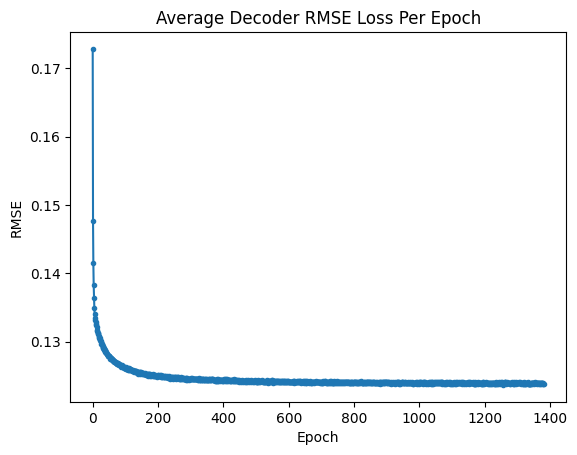

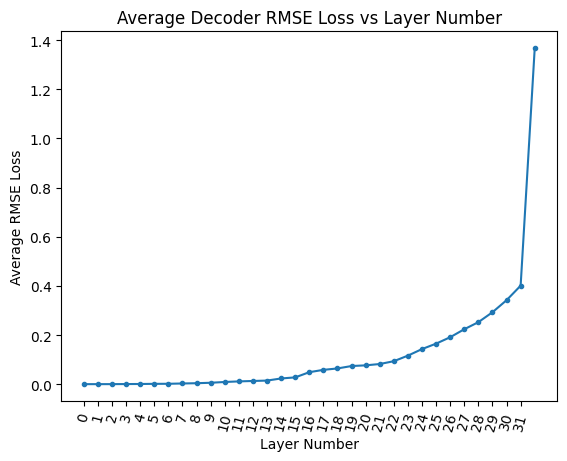

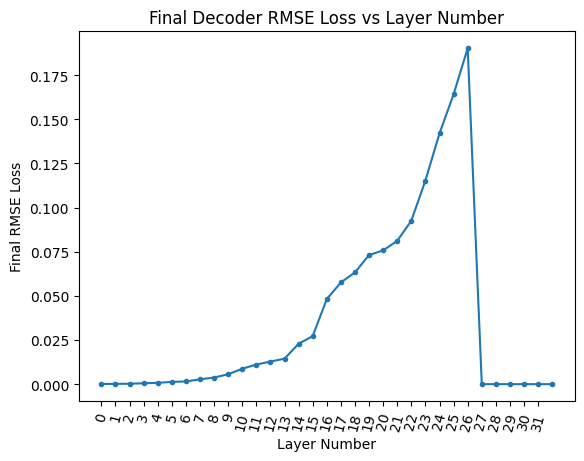

Saved: /home/vdhanraj/Neurosymbolic-LLM/Programs/models/encoders_state_dict_20250413.pth and models/encoders_20250413.pth
Saved: /home/vdhanraj/Neurosymbolic-LLM/Programs/models/decoders_state_dict_20250413.pth and models/decoders_20250413.pth
Running Error Statistics for Testing Data
--------- Layer 0 ---------
Average Error: 2.70492684841156 digits out of 3
Average Problem Type Error: 404 out of 464
Average Error Rate per Digit: tensor([0.2266, 0.2236, 0.2266, 0.0000, 0.0000], device='cuda:0')
--------- Layer 1 ---------
Average Error: 2.676306903362274 digits out of 3
Average Problem Type Error: 0 out of 464
Average Error Rate per Digit: tensor([0.2266, 0.2236, 0.2188, 0.0000, 0.0000], device='cuda:0')
--------- Layer 2 ---------
Average Error: 2.645922839641571 digits out of 3
Average Problem Type Error: 0 out of 464
Average Error Rate per Digit: tensor([0.2266, 0.2217, 0.2119, 0.0000, 0.0000], device='cuda:0')
--------- Layer 3 ---------
Average Error: 2.616258144378662 digits out

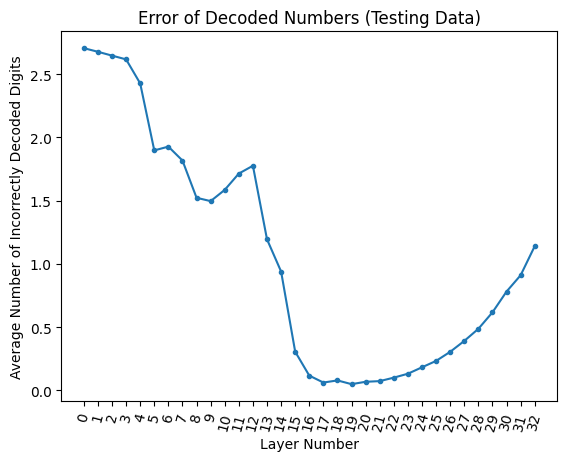

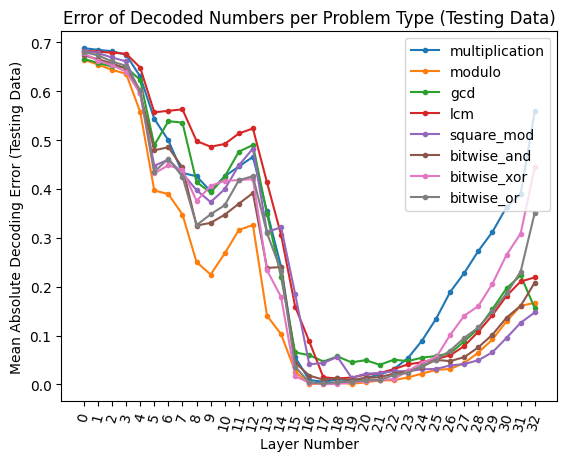

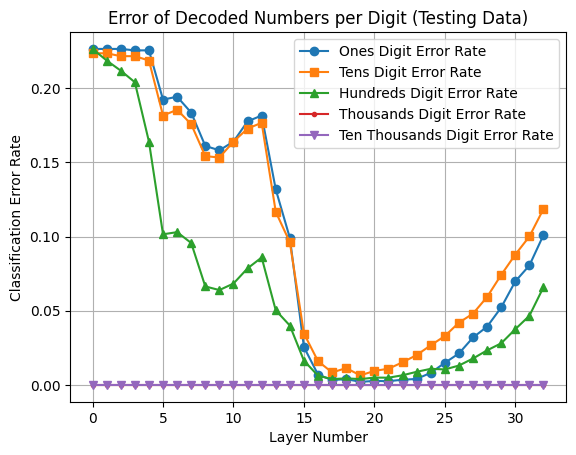

Minimum Error: 0.04924978036433458 and problem type error: 0 at layer 19
Running Error Statistics for Training Data
--------- Layer 0 ---------
Average Error: 2.698892116546631 digits out of 3
Average Problem Type Error: 28 out of 32
Average Error Rate per Digit: tensor([0.0233, 0.0233, 0.0232, 0.0000, 0.0000], device='cuda:0')
--------- Layer 1 ---------
Average Error: 2.672417163848877 digits out of 3
Average Problem Type Error: 0 out of 32
Average Error Rate per Digit: tensor([0.0233, 0.0233, 0.0229, 0.0000, 0.0000], device='cuda:0')
--------- Layer 2 ---------
Average Error: 2.640103340148926 digits out of 3
Average Problem Type Error: 0 out of 32
Average Error Rate per Digit: tensor([0.0233, 0.0233, 0.0219, 0.0000, 0.0000], device='cuda:0')
--------- Layer 3 ---------
Average Error: 2.6054725646972656 digits out of 3
Average Problem Type Error: 0 out of 32
Average Error Rate per Digit: tensor([0.0233, 0.0233, 0.0204, 0.0000, 0.0000], device='cuda:0')
--------- Layer 4 ---------
Av

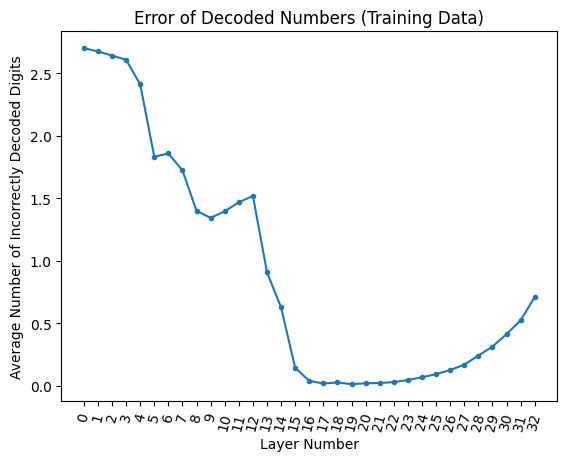

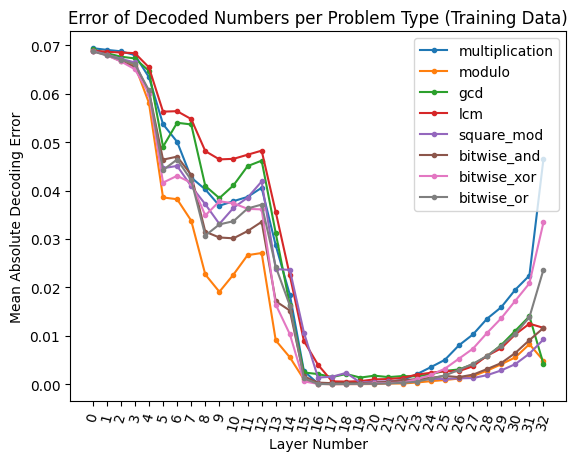

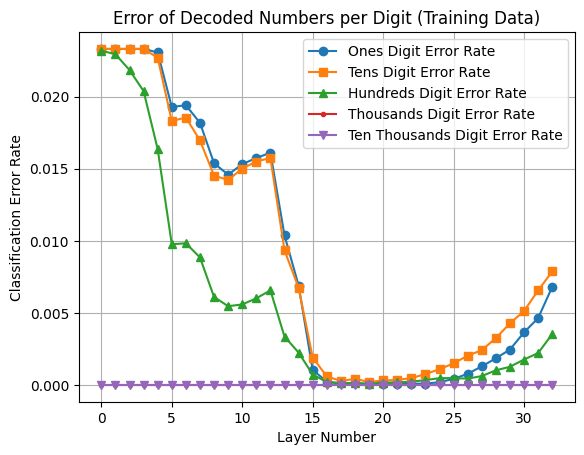

In [13]:

    plt.plot(decoding_losses.mean(axis=0)[:j], marker=".")
    plt.title("Average Decoder RMSE Loss Per Epoch")
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss Per Epoch": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[:j].mean(axis=0), marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Average Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Average RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[j], marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Final Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Final RMSE Loss")
    plt.xlabel("Layer Number")
    if log_wandb:
        wandb.log({f"Final Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()


    if not os.path.exists("./models"):
        os.mkdir("./models")
    torch.save(encoders.state_dict(), f"{curr_dir}/models/encoders_state_dict_{curr_date}.pth")
    torch.save(encoders,              f"{curr_dir}/models/encoders_{curr_date}.pth")
    print("Saved:", f"{curr_dir}/models/encoders_state_dict_{curr_date}.pth", "and", f"models/encoders_{curr_date}.pth")
    torch.save(decoders.state_dict(), f"{curr_dir}/models/decoders_state_dict_{curr_date}.pth")
    torch.save(decoders,              f"{curr_dir}/models/decoders_{curr_date}.pth")
    print("Saved:", f"{curr_dir}/models/decoders_state_dict_{curr_date}.pth", "and", f"models/decoders_{curr_date}.pth")

    ####################################################################################################
    
    print("Running Error Statistics for Testing Data")

    #errors_per_pt = {layer_num.item() : {pt: [] for pt in possible_problems} for n, layer_num in enumerate(layer_numbers)}
    errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in problem_type}

    VSA_predictions = []
    label_VSAs      = []
    rows_to_print  = 0
    verbose = 1 # 0, 1, 2
    errors = np.zeros(len(layer_numbers))
    lowest_error_layer = 0
    lowest_error       = complexity + 1
    lowest_pt_error    = np.inf
    calculate_digit_error = True # Measure total number of errors per digit
    per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
    exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
    with torch.no_grad():
        for n, layer in enumerate(layer_numbers):
            row_count = 0
            if verbose:
                print("--------- Layer", layer.item(), "---------")
            e = 0
            for batch_idx, (data, labels) in enumerate(testing_encoder_data_loaders[n]):
                row_count += len(data)
                pred = encoders[n](data)
                decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                decoded_problem_types, _, _ = SE.decode_problem_type(pred)
                actual_problem_types, _, _  = SE.decode_problem_type(labels)
                if calculate_digit_error:
                    n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                    n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                    batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                    per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                    #print(per_digit_error)
                    per_digit_errors[layer.item()] += per_digit_error
                else:
                    batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                    batch_error = batch_error / 2 * len(data) / (test_data_rounds * max_batch_size)
                for k, curr_pt in enumerate(actual_problem_types):
                    errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
                for r in range(rows_to_print):
                    print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                    print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                    print("Decoded problem type:", decoded_problem_types[r])
                    print("Actual  problem type:", actual_problem_types[r])
                    #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
                e += batch_error.float().mean().item() 

            errors[n] = e
            per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
            problem_type_error = (decoded_problem_types != actual_problem_types).sum()
            if e < lowest_error:
                lowest_error_layer = layer
                lowest_error       = e
                lowest_pt_error    = problem_type_error

            print("Average Error:", errors[n], "digits out of", complexity+1)
            print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
            # Divide per_digit_errors by row_count and by 2 in order to get per digit error
            print("Average Error Rate per Digit:", per_digit_errors[layer.item()])


    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
    plt.plot(x_ticks, errors, marker=".")
    plt.xticks(x_ticks, rotation=75)
    plt.title("Error of Decoded Numbers (Testing Data)")
    plt.ylabel("Average Number of Incorrectly Decoded Digits")
    plt.xlabel("Layer Number")
    plt.grid(False)
    #plt.savefig("error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    for pt in problem_type:
        x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
        pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
        plt.plot(x_ticks, pt_error, marker=".")
        plt.xticks(x_ticks, rotation=75)
        #plt.close()
    plt.title(f"Error of Decoded Numbers per Problem Type (Testing Data)")
    plt.ylabel("Mean Absolute Decoding Error (Testing Data)")
    plt.xlabel("Layer Number")
    plt.legend(problem_type)
    plt.grid(False)
    #plt.savefig("per_pt_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Problem Type (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    labels = ['Ones Digit Error Rate',
            'Tens Digit Error Rate',
            'Hundreds Digit Error Rate',
            'Thousands Digit Error Rate',
            'Ten Thousands Digit Error Rate',
            'Hundred Thousands Digit Error Rate',
            'Millions Digit Error Rate',
            'Ten Millions Digit Error Rate',
            'Hundred Millions Digit Error Rate',
            ]
    markers = ["o", "s", "^", 
            ".", "v", "*", 
            "<", ">", "1"]

    for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
        plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

    # # Plotting
    # #plt.figure(figsize=(12, 6))
    # plt.plot(layers, digit1, label='Hundreds Digit Error Rate', marker='o')
    # plt.plot(layers, digit2, label='Tens Digit Error Rate', marker='s')
    # plt.plot(layers, digit3, label='Ones Digit Error Rate', marker='^')

    # Adding labels, title, and legend
    plt.title(f"Error of Decoded Numbers per Digit (Testing Data)")
    plt.xlabel('Layer Number')
    plt.ylabel('Classification Error Rate')
    plt.legend()
    plt.grid(True)
    #plt.savefig("per_digit_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Digit (Testing Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    print("Minimum Error:", lowest_error, "and problem type error:", problem_type_error, "at layer", lowest_error_layer.item())#, ", Current running loss:", running_losses[lowest_error_layer.item()])

    ####################################################################################################
    
    print("Running Error Statistics for Training Data")

    #errors_per_pt = {layer_num.item() : {pt: [] for pt in possible_problems} for n, layer_num in enumerate(layer_numbers)}
    errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in problem_type}

    VSA_predictions = []
    label_VSAs      = []
    rows_to_print  = 0
    verbose = 1 # 0, 1, 2
    errors = np.zeros(len(layer_numbers))
    lowest_error_layer = 0
    lowest_error       = complexity + 1
    lowest_pt_error    = np.inf
    calculate_digit_error = True # Measure total number of errors per digit
    per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
    exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
    with torch.no_grad():
        for n, layer in enumerate(layer_numbers):
            row_count = 0
            if verbose:
                print("--------- Layer", layer.item(), "---------")
            e = 0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                row_count += len(data)
                pred = encoders[n](data)
                decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
                actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
                decoded_problem_types, _, _ = SE.decode_problem_type(pred)
                actual_problem_types, _, _  = SE.decode_problem_type(labels)
                if calculate_digit_error:
                    n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                    n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                    batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                    per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                    #print(per_digit_error)
                    per_digit_errors[layer.item()] += per_digit_error
                else:
                    batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                    batch_error = batch_error / 2 * len(data) / (train_data_rounds * max_batch_size)
                for k, curr_pt in enumerate(actual_problem_types):
                    errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
                for r in range(rows_to_print):
                    print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                    print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                    print("Decoded problem type:", decoded_problem_types[r])
                    print("Actual  problem type:", actual_problem_types[r])
                    #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
                e += batch_error.float().mean().item() 

            errors[n] = e
            per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
            problem_type_error = (decoded_problem_types != actual_problem_types).sum()
            if e < lowest_error:
                lowest_error_layer = layer
                lowest_error       = e
                lowest_pt_error    = problem_type_error

            print("Average Error:", errors[n], "digits out of", complexity+1)
            print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
            # Divide per_digit_errors by row_count and by 2 in order to get per digit error
            print("Average Error Rate per Digit:", per_digit_errors[layer.item()])


    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
    plt.plot(x_ticks, errors, marker=".")
    plt.xticks(x_ticks, rotation=75)
    plt.title("Error of Decoded Numbers (Training Data)")
    plt.ylabel("Average Number of Incorrectly Decoded Digits")
    plt.xlabel("Layer Number")
    plt.grid(False)
    #plt.savefig("error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    for pt in problem_type:
        x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)  # Adjust the range as needed
        pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
        plt.plot(x_ticks, pt_error, marker=".")
        plt.xticks(x_ticks, rotation=75)
        #plt.close()
    plt.title(f"Error of Decoded Numbers per Problem Type (Training Data)")
    plt.ylabel("Mean Absolute Decoding Error")
    plt.xlabel("Layer Number")
    plt.legend(problem_type)
    plt.grid(False)
    #plt.savefig("per_pt_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Problem Type (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    labels = ['Ones Digit Error Rate',
            'Tens Digit Error Rate',
            'Hundreds Digit Error Rate',
            'Thousands Digit Error Rate',
            'Ten Thousands Digit Error Rate',
            'Hundred Thousands Digit Error Rate',
            'Millions Digit Error Rate',
            'Ten Millions Digit Error Rate',
            'Hundred Millions Digit Error Rate',
            ]
    markers = ["o", "s", "^", 
            ".", "v", "*", 
            "<", ">", "1"]

    for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
        plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

    # # Plotting
    # #plt.figure(figsize=(12, 6))
    # plt.plot(layers, digit1, label='Hundreds Digit Error Rate', marker='o')
    # plt.plot(layers, digit2, label='Tens Digit Error Rate', marker='s')
    # plt.plot(layers, digit3, label='Ones Digit Error Rate', marker='^')

    # Adding labels, title, and legend
    plt.title(f"Error of Decoded Numbers per Digit (Training Data)")
    plt.xlabel('Layer Number')
    plt.ylabel('Classification Error Rate')
    plt.legend()
    plt.grid(True)
    #plt.savefig("per_digit_error_per_layer.png")
    if log_wandb:
        wandb.log({f"Error of Decoded Numbers per Digit (Training Data)": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()



In [ ]:
# Final version below

In [ ]:
def episode(generator, dialogs, temperature=0.0, top_p=0.9, inference_mode=None,
            max_decoding_length=100, verbose=False):
    
    if type(inference_mode) == type(None):
        inference_mode = generator.model.forward

    prompt_tokens = generator.parse_chat(dialogs)

    max_gen_len = generator.model.params.max_seq_len - 1
    top_p = top_p
    echo = False

    params = generator.model.params
    bsz = len(prompt_tokens)
    assert bsz <= params.max_batch_size, (bsz, params.max_batch_size)

    min_prompt_len = min(len(t) for t in prompt_tokens)
    max_prompt_len = max(len(t) for t in prompt_tokens)
    assert max_prompt_len <= params.max_seq_len
    total_len = min(params.max_seq_len, max_gen_len + max_prompt_len)

    pad_id = generator.tokenizer.pad_id
    tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long)
    for k, t in enumerate(prompt_tokens):
        tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long)

    prev_pos = 0
    eos_reached = torch.tensor([False] * bsz)
    input_text_mask = tokens != pad_id

    stop_tokens = torch.tensor(list(generator.tokenizer.stop_tokens))

    transitions = []
    curr_token = 0
    list_of_probs  = []
    list_of_logits = []
    h_stacks = []
    for cur_pos in range(min_prompt_len, total_len):
        logits, h_stack, h = inference_mode(tokens[:, prev_pos:cur_pos], prev_pos, curr_token=curr_token verbose=verbose)
        # Shape of logits are (batch_size, total_sequence_length, num_tokens)
        h_stacks += [h_stack]
        # probs are intentionally being calculated here, so that it contains an extra token (the stop token), to help with loss calculation
        probs = torch.softmax(logits[:, -1,:] / 1, dim=-1)
        list_of_probs  += [probs]
        list_of_logits += [logits[:,-1,:]]
        new_logits = logits
        if temperature > 0:
            probs = torch.softmax(new_logits[:, -1] / temperature, dim=-1)
            #print(logits, logits.shape)
            next_token = sample_top_p(probs, top_p)
        else:
            next_token = torch.argmax(new_logits[:, -1], dim=-1)
        if curr_token > max_decoding_length:
            next_token = stop_tokens[0]
        next_token = next_token.reshape(-1)
        # only replace token if prompt has already been generated
        next_token = torch.where(
            input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token
        )
        tokens[:, cur_pos] = next_token

        eos_reached |= (~input_text_mask[:, cur_pos]) & (
            torch.isin(next_token, stop_tokens)
        )
        prev_pos = cur_pos
        if all(eos_reached):
            break

        curr_token += 1
        
    list_of_probs = torch.stack(list_of_probs)
    list_of_logits = torch.stack(list_of_logits)

    out_tokens = []
    for i, toks in enumerate(tokens.tolist()):
        # cut to max gen len
        start = 0 if echo else len(prompt_tokens[i])
        toks = toks[start : len(prompt_tokens[i]) + max_gen_len]
        # cut to after eos tok if any
        for stop_token in generator.tokenizer.stop_tokens:
            try:
                eos_idx = toks.index(stop_token)
                toks = toks[:eos_idx]
            except ValueError:
                pass
        out_tokens.append(toks)

    return h_stacks, list_of_probs, list_of_logits, out_tokens
